### Libraries

In [ ]:
import random
import numpy as np
import sklearn
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from sklearn.datasets import fetch_20newsgroups

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

## 1. Data Preparation

### Load dataset

In [ ]:
newsgroups = fetch_20newsgroups(random_state=22,subset='all')

#### Backup method

In [29]:
newsgroups = joblib.load("20newsgroups_full.pkl")

FileNotFoundError: [Errno 2] No such file or directory: '20newsgroups_full.pkl'

In [ ]:
newsgroups

{'data': ['Subject: Re: MVP \'92 Revisited\nFrom: grabiner@math.harvard.edu (David Grabiner)\n <9479@blue.cis.pitt.edu><1993Apr22.020832.11663@island.COM> <9709@blue.cis.pitt.edu><1r6hf4INNc16@gap.caltech.edu>\nOrganization: /etc/organization\nNntp-Posting-Host: germain.harvard.edu\nIn-reply-to: shippert@cco.caltech.edu\'s message of 22 Apr 1993 16:34:44 GMT\nLines: 46\n\nIn article <1r6hf4INNc16@gap.caltech.edu>, Tim Shippert writes:\n\n> \tIdeally, DHs "should" be the strongest offensive players, because\n> any schmoe can play DH if he can hit.  That would take care of position\n> corrected anomolies such as Frank\'s.  Since that is not the case (and why\n> not?  Is it always this way?) then we are going to have trouble finding the\n> true value of DHs using the same models as that for position players.\n\nThere are several reasons for this difference.  The main reason is that\ngood hitters in their prime (such as Frank Thomas and Danny Tartabull)\nare rarely regular DH\'s, even if t

In [ ]:
x_raw = newsgroups.data
x = newsgroups.target
target_names = newsgroups.target_names
len(x_raw), len(target_names) # 18k samples, 20 classes

(18846, 20)

### Samples per class

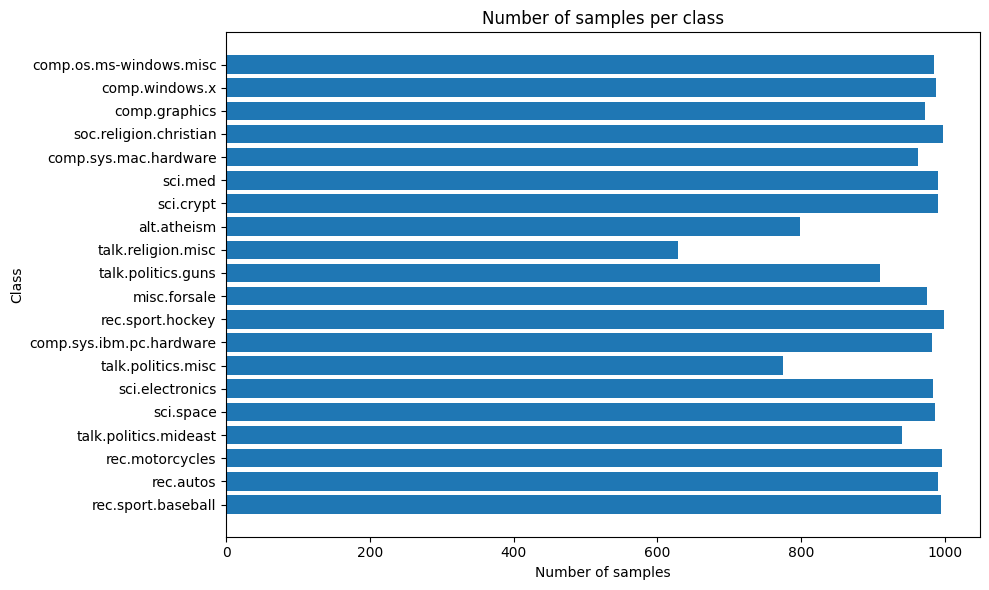

In [ ]:
# count samples per class
counts = Counter(x)

labels = [target_names[i] for i in counts.keys()]
values = list(counts.values())

# horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(labels, values)
plt.title("Number of samples per class")
plt.xlabel("Number of samples")
plt.ylabel("Class")
plt.tight_layout()
plt.show()

Some class unbalancing 

### Preprocessing

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text) # remove URLs
    text = re.sub(r'\S+@\S+\.\S+', '', text) # rmove emails
    text = re.sub(r'[0-9]{2}\/[0-9]{2}\/[0-9]{4}', '', text) # remove dates
    text = re.sub(r'\d{1,2}[-]\d{3}[-]\d{3}[-]\d{4}', '', text) # remove phone numbers
    text = re.sub(r'[^\w|^\s]', '', text.lower()) # remove punctuation and lowercase
    tokens = word_tokenize(text) # tokenize
    tokens = [word for word in tokens if word not in stop_words] # remove stopwords
    tokens = [lemmatizer.lemmatize(t) for t in tokens] # lemmatization
    return tokens

preprocessed_corpus = [preprocess_text(doc) for doc in x_raw]
x_clean = [" ".join(toks) for toks in preprocessed_corpus] # join tokens back to strings

In [ ]:
print("Example of a cleaned text:\n", x_clean[0][:400])

Example of a cleaned text:
 mamatha devineni ratnam subject pen fan reaction organization post office carnegie mellon pittsburgh pa line 12 nntppostinghost po4andrewcmuedu sure bashers pen fan pretty confused lack kind post recent pen massacre devil actually bit puzzled bit relieved however going put end nonpittsburghers relief bit praise pen man killing devil worse thought jagr showed much better regular season stats also l


### Most frequent words

In [ ]:
all_words = " ".join(x_clean).split() # every word in corpus
word_counts = Counter(all_words) # counter hashmap {word:frequency}
most_common_words = word_counts.most_common(20) # 20 most common words

for word, freq in most_common_words:
    print(f"{word:15} {freq}")

|               28784
line            21404
subject         20456
organization    18866
one             15061
would           14764
writes          13328
article         11877
dont            9672
like            9608
people          9524
university      9456
know            9220
get             9026
1               8881
nntppostinghost 8063
time            7819
think           7694
also            7221
x               7020


Might be useful to remove the word subject as it is just the name of an e-mail field

### Data split

In [ ]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 22
# split in 60-20-20 (stratified-> matainging class proprtions)
x_train_raw, x_b, y_train, y_b = train_test_split(x_clean, x, train_size=0.6, test_size=0.4, stratify=x, random_state=RANDOM_STATE)
x_val_raw, x_test_raw, y_val, y_test = train_test_split(x_b, y_b, train_size=0.5, test_size=0.5, stratify=y_b, random_state=RANDOM_STATE)

In [ ]:
print(f"Train: {len(x_train_raw)}, Val: {len(x_val_raw)}, Test: {len(x_test_raw)}")

Train: 11307, Val: 3769, Test: 3770


## 2. Feature Extraction

In [ ]:
# vectorizing the dataset to use it with linear regression
vectorizer_lr = TfidfVectorizer(sublinear_tf=True)
X_train_tfidf_lr = vectorizer_lr.fit_transform(x_train_raw)
X_val_tfidf_lr   = vectorizer_lr.transform(x_val_raw)
X_test_tfidf_lr  = vectorizer_lr.transform(x_test_raw)

In [ ]:
print("Train shape:", X_train_tfidf_lr.shape)
print("Val shape:  ", X_val_tfidf_lr.shape)
print("Test shape: ", X_test_tfidf_lr.shape)

Train shape: (11307, 121945)
Val shape:   (3769, 121945)
Test shape:  (3770, 121945)


- normal: 116k -> 0.906
- 1,2 ngrams: 1.1m -> 0.915
- min_df=2: 46k -> 0.907
- min_df=2, sublinear: 46k -> 0.9124
- sublinear: 116k -> 0.9156

In [ ]:
vectorizer_lr.vocabulary_ # mapping words-numbers

{'ray': 89509,
 'ingles': 55661,
 'subject': 100794,
 'yeah': 115521,
 'right': 92048,
 'organization': 81143,
 'university': 107791,
 'michigan': 70721,
 'engineering': 41907,
 'ann': 20752,
 'arbor': 21670,
 'line': 62214,
 '49': 10935,
 'distribution': 38717,
 'world': 113235,
 'nntppostinghost': 78387,
 'agarenginumichedu': 19040,
 'article': 22129,
 'charley': 29990,
 'wingate': 112588,
 'writes': 113436,
 'benedikt': 24934,
 'rosenau': 92708,
 'revelation': 91689,
 'thing': 103992,
 'youre': 115845,
 'talking': 102561,
 'intellectual': 56129,
 'engagement': 41886,
 'well': 111774,
 'obviously': 79933,
 'risk': 92192,
 'one': 80595,
 'take': 102516,
 'ah': 19173,
 'core': 33605,
 'question': 88660,
 'let': 61688,
 'suggest': 101063,
 'scenario': 94310,
 'grant': 49377,
 'god': 48848,
 'exists': 43354,
 'us': 108443,
 'communicate': 32079,
 'human': 53510,
 'said': 93661,
 'taking': 102529,
 'form': 46065,
 'paraphrased': 82620,
 'word': 113157,
 'infinitely': 55511,
 'powerful': 8

In [ ]:
dictionary = vectorizer_lr.get_feature_names_out()
print(dictionary[:10]) # the first 10 words in the dictionary
len(dictionary) # there are 116k different words in the dictionary

['00' '000' '0000' '000000' '00000000' '0000000004' '00000000b' '00000001'
 '00000001b' '00000010']


116618

## 3. Models

### Multinomial Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

model_mlr = LogisticRegression(
    max_iter=3000,
    n_jobs=-1,
    C=50,
    random_state=RANDOM_STATE
)

model_mlr.fit(X_train_tfidf_lr, y_train)
y_val_pred  = model_mlr.predict(X_val_tfidf_lr)
y_test_pred = model_mlr.predict(X_test_tfidf_lr)

val_ce  = f1_score(y_val, y_val_pred, average='macro')
val_ce = f1_score(y_test, y_test_pred, average='macro')

print(f"Validation f1: {val_ce:.4f}")
print(f"Test f1: {val_ce:.4f}")

## 4. Hyperparameter Optimization

### Grid-search for MLR

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report


# Define grid of hyperparameters to test
param_grid = {
    'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 3, 5, 10, 20, 50, 100],      # regularization strength
    'penalty': ['l2'],             # lbfgs only supports L2
}

# Grid search with macro-F1 optimization
grid = GridSearchCV(
    model_mlr,
    param_grid,
    scoring='f1_macro',
    cv=3,                 # 3-fold cross validation
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train_tfidf_lr, y_train)

print(f"Best params: {grid.best_params_}")
print(f"Best macro-F1 (CV): {grid.best_score_:.4f}")

# Evaluate on validation set
best_mlr = grid.best_estimator_
y_val_pred = best_mlr.predict(X_val_tfidf_lr)
val_ce = f1_score(y_val, y_val_pred, average='macro')
print(f"Validation macro-F1: {val_ce:.4f}")


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'C': 100, 'penalty': 'l2'}
Best macro-F1 (CV): 0.8978
Validation macro-F1: 0.9227


## 5. Results

### Classification Report for MLR

In [ ]:
print(classification_report(y_test, y_test_pred, target_names=target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.89      0.88      0.88       160
           comp.graphics       0.82      0.89      0.85       194
 comp.os.ms-windows.misc       0.89      0.89      0.89       197
comp.sys.ibm.pc.hardware       0.83      0.82      0.83       197
   comp.sys.mac.hardware       0.90      0.91      0.90       192
          comp.windows.x       0.92      0.89      0.91       198
            misc.forsale       0.84      0.90      0.87       195
               rec.autos       0.94      0.91      0.92       198
         rec.motorcycles       0.97      0.95      0.96       199
      rec.sport.baseball       0.97      0.99      0.98       199
        rec.sport.hockey       0.99      0.97      0.98       200
               sci.crypt       0.98      0.96      0.97       198
         sci.electronics       0.88      0.90      0.89       197
                 sci.med       0.96      0.92      0.94       198
         

### Confusion Matrix for MLR

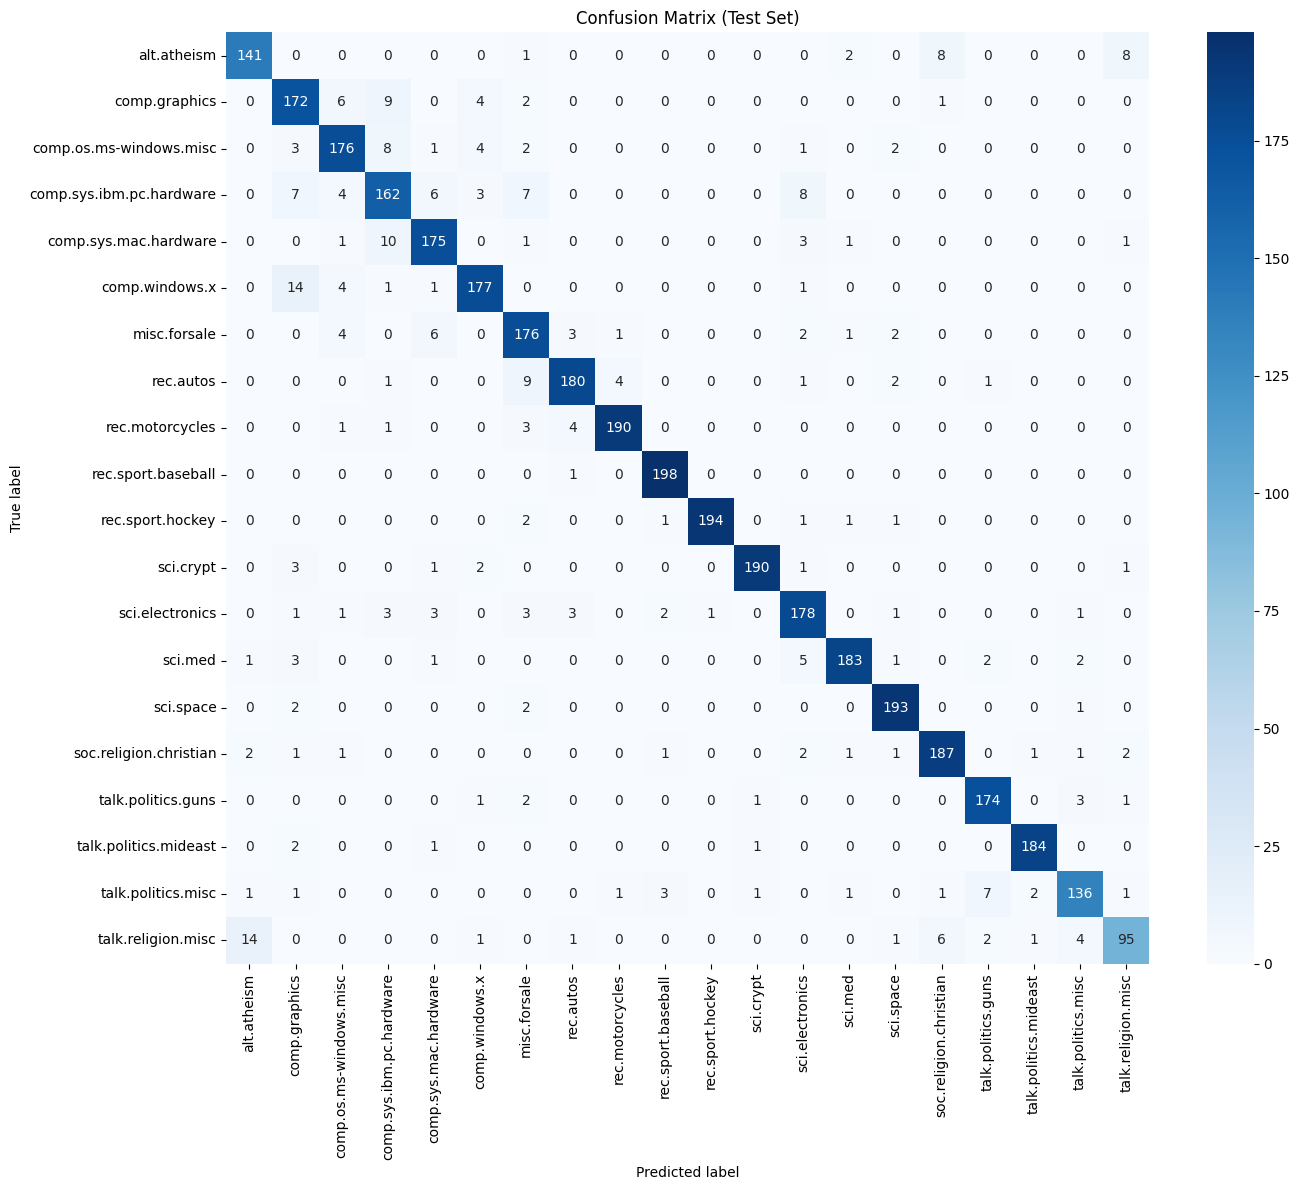

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names
)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

### Explainability for MLP

In [ ]:
coefs = model_mlr.coef_
print(coefs.shape)

(20, 116618)


In [ ]:
def show_top_features(class_id, top_n=10):
    """Display top positive and negative weighted words for a given class."""
    class_name = target_names[class_id]
    weights = coefs[class_id]

    # top positive → strong evidence FOR this class
    top_pos_idx = np.argsort(weights)[-top_n:][::-1]
    # top negative → evidence AGAINST this class
    top_neg_idx = np.argsort(weights)[:top_n]

    print(f"\nClass: {class_name}")
    print(" Top positive words:")
    for i in top_pos_idx:
        print(f"  {dictionary[i]:<20}  +{weights[i]:.3f}")

    print("\nTop negative words:")
    for i in top_neg_idx:
        print(f"  {dictionary[i]:<20}  {weights[i]:.3f}")

for i in range(20):
    show_top_features(i)



Class: alt.atheism
 Top positive words:
  atheist               +11.093
  god                   +9.244
  keith                 +8.239
  atheism               +6.748
  mathew                +6.139
  altatheism            +6.000
  bible                 +5.734
  rushdie               +5.617
  islamic               +5.583
  benedikt              +5.470

Top negative words:
  usa                   -2.951
  use                   -2.021
  email                 -2.003
  replyto               -1.993
  thanks                -1.925
  internet              -1.846
  center                -1.842
  window                -1.839
  service               -1.720
  stephen               -1.709

Class: comp.graphics
 Top positive words:
  graphic               +13.619
  image                 +11.981
  3d                    +11.179
  3do                   +7.776
  format                +7.078
  polygon               +6.868
  tiff                  +6.243
  file                  +6.130
  compgraphics         

In [ ]:
importance = np.linalg.norm(coefs, axis=0)
top_idx = np.argsort(importance)[-20:][::-1]
print("\nMost globally informative words:")
for i in top_idx:
    print(f"{dictionary[i]:<20} {importance[i]:.3f}")


Most globally informative words:
window               25.484
car                  24.109
bike                 19.863
sale                 19.828
space                18.363
mac                  18.101
dod                  16.920
god                  16.632
game                 16.393
gun                  15.650
christian            15.388
graphic              14.224
hockey               13.678
monitor              13.387
file                 13.331
team                 13.104
apple                13.095
clipper              13.034
baseball             12.901
image                12.857


## MLP

In [ ]:
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader


import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics.classification import F1Score
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, RichProgressBar

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score

### Vectorization

In [ ]:
vectorizer_mlp = TfidfVectorizer(
    max_features=50000,        # try 10k / 20k / 30k
    ngram_range=(1, 2),        # unigrams + bigrams
    min_df=2,                  # drop very rare terms
    sublinear_tf=True,
)

X_train_tfidf_mlp = vectorizer_mlp.fit_transform(x_train_raw)
X_val_tfidf_mlp   = vectorizer_mlp.transform(x_val_raw)
X_test_tfidf_mlp  = vectorizer_mlp.transform(x_test_raw)

### Data Loaders

In [ ]:


X_train = torch.tensor(X_train_tfidf_mlp.toarray(), dtype=torch.float32)
X_val   = torch.tensor(X_val_tfidf_mlp.toarray(), dtype=torch.float32)
X_test  = torch.tensor(X_test_tfidf_mlp.toarray(), dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.long)
y_val   = torch.tensor(y_val, dtype=torch.long)
y_test  = torch.tensor(y_test, dtype=torch.long)

train_set = TensorDataset(X_train, y_train)
val_set   = TensorDataset(X_val, y_val)
test_set  = TensorDataset(X_test, y_test)

batch_size = 1024
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=1)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=1)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=1)

### Model Definition

#### First Version

#### Enhanced Version

In [ ]:


class LitFinalMLPClassifier(pl.LightningModule):
    def __init__(
        self,
        input_dim,
        num_classes,
        hidden=64,
        dropout=0.5,
        lr=1e-3,
        weight_decay=1e-4
    ):
        super().__init__()
        self.save_hyperparameters()

        # layers
        self.fc1 = nn.Linear(input_dim, hidden)
        self.bn1 = nn.BatchNorm1d(hidden)
        self.fc_out = nn.Linear(hidden, num_classes)
        self.dropout = nn.Dropout(dropout)

        # metrics
        self.val_f1  = F1Score(task="multiclass", num_classes=num_classes, average="macro")
        self.test_f1 = F1Score(task="multiclass", num_classes=num_classes, average="macro")

    # forward
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc_out(x)
        return x

    # shared step
    def _shared_step(self, batch):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        return loss, preds, y

    # training
    def training_step(self, batch, batch_idx):
        loss, preds, y = self._shared_step(batch)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    # val
    def validation_step(self, batch, batch_idx):
        loss, preds, y = self._shared_step(batch)
        f1 = self.val_f1(preds, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_f1", f1, prog_bar=True)

    # test
    def test_step(self, batch, batch_idx):
        loss, preds, y = self._shared_step(batch)
        f1 = self.test_f1(preds, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_f1", f1, prog_bar=True)

    # predict
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x = batch[0]
        logits = self(x)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        return {"preds": preds.cpu(), "probs": probs.cpu()}

    # reset
    def on_validation_epoch_end(self):
        self.val_f1.reset()
    def on_test_epoch_end(self):
        self.test_f1.reset()

    def configure_optimizers(self):
        opt = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay
        )
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt,
            mode="min",
            factor=0.5,
            patience=2,
            min_lr=1e-6
        )
        return {"optimizer": opt, "lr_scheduler": {"scheduler": sched, "monitor": "val_loss"}}


### Trainer and Callbacks

In [ ]:
#logger = TensorBoardLogger("lightning_logs", name="mlp_tfidf")

checkpoint_cb = ModelCheckpoint(
    monitor="val_f1",
    mode="max",
    save_top_k=1,
    filename="mlp-{epoch:02d}-{val_f1:.3f}"
)

early_stop_cb = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5,
    verbose=True,
    min_delta=0.001
)

progress_cb = RichProgressBar()

trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[checkpoint_cb, early_stop_cb, progress_cb],
    logger=False,
    #log_every_n_steps=50
)









trainer_autoencoder = pl.Trainer(
    max_epochs=100,
    callbacks=[early_stop_cb, progress_cb],
    logger=False,
    #log_every_n_steps=50
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


### Model Instantiation

#### First Version

#### Enhanced Version

In [ ]:
input_dim = X_train_tfidf_mlp.shape[1]
num_classes = len(target_names)
mlp_final = LitFinalMLPClassifier(input_dim=input_dim,
    num_classes=num_classes)
print(mlp_final)

LitFinalMLPClassifier(
  (fc1): Linear(in_features=50000, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_out): Linear(in_features=64, out_features=20, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (val_f1): MulticlassF1Score()
  (test_f1): MulticlassF1Score()
)


### Training

In [ ]:
trainer.fit(mlp_final, train_loader, val_loader)

### Testing

In [ ]:
trainer.test(mlp_final, test_loader) # test set has labels here

In [ ]:
trainer.save_checkpoint("mlp_f1_0.9266c.ckpt")

### Evaluation

In [ ]:
model_best = LitFinalMLPClassifier.load_from_checkpoint("mlp_f1_0.9266c.ckpt")

In [ ]:
y_test_preds = trainer.predict(mlp_final, test_loader)

In [ ]:
y_true = torch.cat([y for _, y in test_loader])
y_pred = torch.cat([p["preds"] for p in y_test_preds])

In [ ]:

print(classification_report(y_test, y_pred, target_names=target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.91      0.90      0.90       160
           comp.graphics       0.81      0.84      0.82       194
 comp.os.ms-windows.misc       0.90      0.86      0.88       197
comp.sys.ibm.pc.hardware       0.81      0.86      0.83       197
   comp.sys.mac.hardware       0.93      0.94      0.94       192
          comp.windows.x       0.93      0.92      0.93       198
            misc.forsale       0.88      0.91      0.89       195
               rec.autos       0.94      0.93      0.94       198
         rec.motorcycles       0.97      0.96      0.96       199
      rec.sport.baseball       0.98      0.97      0.97       199
        rec.sport.hockey       0.97      0.98      0.98       200
               sci.crypt       0.98      0.97      0.98       198
         sci.electronics       0.87      0.90      0.89       197
                 sci.med       0.95      0.92      0.94       198
         

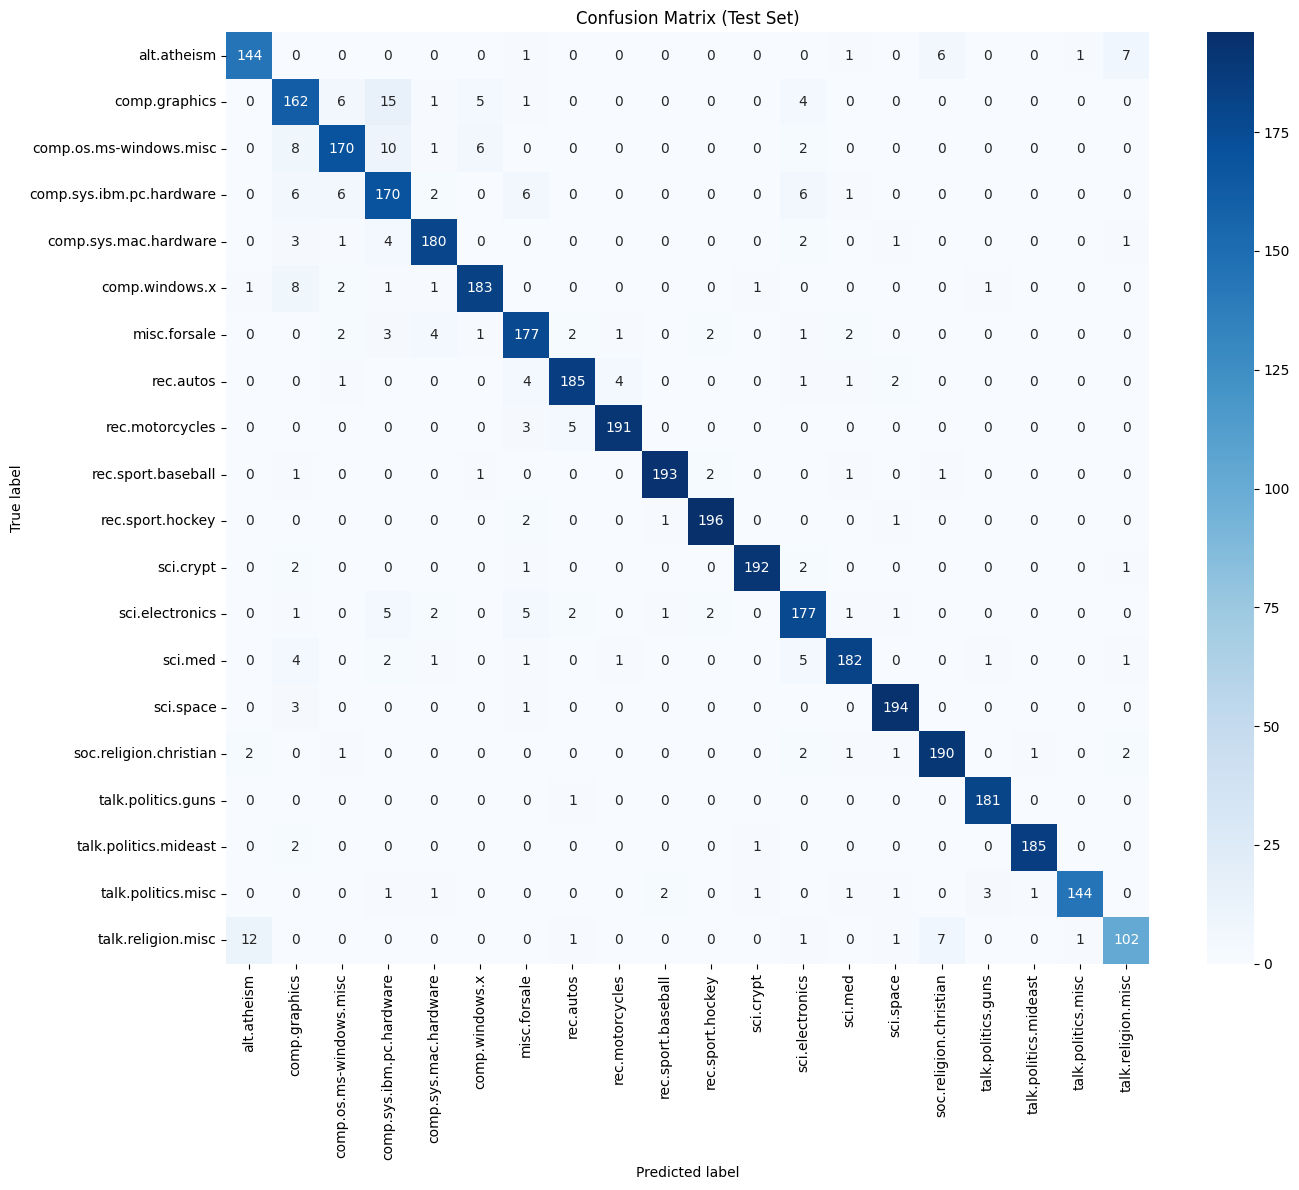

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names
)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

As we can see, the model performs very well across almost all classes. The only classes that tend to be confused more often are atheism and religion, as well as windows and graphics.

In [ ]:

f1 = f1_score(y_true, y_pred, average='macro')
print(f"Test set F1-score: {f1:.4f}")

Test set F1-score: 0.9269


In [202]:
trainer.save_checkpoint("mlp_f1_0.92075.ckpt")


- mega nn, 100k features -> 0.9193
- 1 hidden layer nn, 50k features -> 0.9207

# Autoencoder

In [ ]:
from torchmetrics.regression import MeanSquaredError

## Model definition

### First Version

In [ ]:

class LitAutoencoder(pl.LightningModule):
    def __init__(
        self,
        input_dim,

        pre_embedding=2048,
        embedding=1024,
        dropout=0.5,
        lr=1e-3,
        weight_decay=1e-4,
    ):
        super().__init__()
        self.save_hyperparameters()

        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, pre_embedding),
            nn.BatchNorm1d(pre_embedding),
            nn.LeakyReLU(),
            nn.Linear(pre_embedding, embedding),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
        )

        
        self.decoder = nn.Sequential(
            nn.Linear(embedding, pre_embedding),
            nn.LeakyReLU(),
            nn.Linear(pre_embedding, input_dim),
            nn.Sigmoid(),  
        )

        self.val_ce = F.binary_cross_entropy # We can use Bce to compute the reconstruction error as the input features are normalized

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def encode(self, x):

        return self.encoder(x)

    def _shared_step(self, batch):
        x, _ = batch
        x_hat = self(x)
        loss = F.binary_cross_entropy(x_hat, x)
        return loss, x_hat, x

    def training_step(self, batch, batch_idx):
        loss, _, _ = self._shared_step(batch)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, x_hat, x = self._shared_step(batch)
        ce = self.val_ce(x_hat, x)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_ce", ce, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, x_hat, x = self._shared_step(batch)
        ce = self.val_ce(x_hat, x)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_ce", ce, prog_bar=True)



    def configure_optimizers(self):
        opt = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay
        )
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, mode="min", factor=0.5, patience=2, min_lr=1e-6
        )
        return {"optimizer": opt, "lr_scheduler": {"scheduler": sched, "monitor": "val_loss"}}


### Enhanced Version

Adding noise and regularization to try to improve the latent space representation

In [ ]:
class RegularizedAutoencoder(pl.LightningModule):
    def __init__(
        self,
        input_dim,
        embedding=1024,
        pre_embedding=2048,
        dropout=0.3,
        lr=1e-3,
        weight_decay=1e-4,
        lambda_l1=1e-3,   
        lambda_l2=1e-3,   
        noise_std=0.1,    
    ):
        super().__init__()
        self.save_hyperparameters()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, pre_embedding),
            nn.BatchNorm1d(pre_embedding),
            nn.LeakyReLU(),
            nn.Linear(pre_embedding, embedding),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(embedding, pre_embedding),
            nn.LeakyReLU(),
            nn.Linear(pre_embedding, input_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z
    def encode(self,x):
        return self.encoder(x)
    def _shared_step(self, batch):
        x, _ = batch

        # Aggiungiamo rumore (denoising AE)
        noisy_x = x + self.hparams.noise_std * torch.randn_like(x)

        # Forward
        x_hat, z = self(noisy_x)

        # Ricostruzione
        recon_loss = F.binary_cross_entropy(x_hat, x)

        # Regolarizzazione: sparsità (L1) e L2 sul latent
        l1_reg = torch.mean(torch.abs(z))
        l2_reg = torch.mean(z ** 2)

        total_loss = (
            recon_loss
            + self.hparams.lambda_l1 * l1_reg
            + self.hparams.lambda_l2 * l2_reg
        )

        return total_loss, recon_loss, l1_reg, l2_reg

    def training_step(self, batch, batch_idx):
        loss, recon_loss, l1, l2 = self._shared_step(batch)
        self.log_dict({
            "train_loss": loss,
            "train_recon": recon_loss,
            "train_l1": l1,
            "train_l2": l2
        }, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, recon_loss, l1, l2 = self._shared_step(batch)
        self.log_dict({
            "val_loss": loss,
            "val_recon": recon_loss,
            "val_l1": l1,
            "val_l2": l2
        }, prog_bar=True)

    def configure_optimizers(self):
        opt = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay
        )
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, mode="min", factor=0.5, patience=3
        )
        return {"optimizer": opt, "lr_scheduler": {"scheduler": sched, "monitor": "val_loss"}}


## Model Instantiation

In [ ]:
input_dim = X_train_tfidf_mlp.shape[1]
num_classes = len(target_names)
autoencoder = RegularizedAutoencoder(input_dim=input_dim,embedding=1000,pre_embedding=5000)
print(autoencoder)

RegularizedAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=50000, out_features=5000, bias=True)
    (1): BatchNorm1d(5000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=5000, out_features=1000, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.3, inplace=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1000, out_features=5000, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=5000, out_features=50000, bias=True)
    (3): Sigmoid()
  )
)


## Training

In [ ]:
torch.set_float32_matmul_precision('medium') 

In [ ]:
trainer_autoencoder.fit(autoencoder, train_loader, test_loader)

In [ ]:
model = LitFinalMLPClassifier.load_from_checkpoint("mlp_f1_0.92075.ckpt")

In [ ]:
trainer_autoencoder.test(autoencoder, dataloaders=test_loader) # test set has labels here

### Embeddings Generation

In [ ]:
embeddings_train = []
with torch.no_grad():
    for x, y in train_loader:
        z = autoencoder.encode(x)  
        embeddings_train.append(z.cpu())


In [ ]:
embeddings_val = []
with torch.no_grad():
    for x, y in val_loader:
        z = autoencoder.encode(x)  
        embeddings_val.append(z.cpu())


In [ ]:
embeddings_test = []
with torch.no_grad():
    for x, y in test_loader:
        z = autoencoder.encode(x)  
        embeddings_test.append(z.cpu())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader


embeddings_train = torch.cat(embeddings_train)
embeddings_val = torch.cat(embeddings_val)
embeddings_test = torch.cat(embeddings_test)


In [ ]:
embeddings_train.shape # shape check

torch.Size([11307, 1000])

### Data Loaders for the MLP discriminator

In [ ]:
y_train_e = torch.from_numpy(y_train)
y_val_e = torch.from_numpy(y_val)
y_test_e = torch.from_numpy(y_test)

embed_dataset_train = TensorDataset(embeddings_train, y_train_e)
embed_dataset_val = TensorDataset(embeddings_val, y_val_e)
embed_dataset_test= TensorDataset(embeddings_test, y_test_e)

batch_size = 1024
embed_loader_train = DataLoader(embed_dataset_train, batch_size=batch_size, shuffle=True)
embed_loader_val = DataLoader(embed_dataset_val, batch_size=batch_size, shuffle=True)
embed_loader_test = DataLoader(embed_dataset_test, batch_size=batch_size, shuffle=True)

### Discriminator instantiation

In [ ]:

num_classes = len(target_names)
embeddings_mlp_discriminator= LitFinalMLPClassifier(input_dim=1000,hidden=500,
    num_classes=num_classes)
print(embeddings_mlp_discriminator)

LitFinalMLPClassifier(
  (fc1): Linear(in_features=1000, out_features=500, bias=True)
  (bn1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_out): Linear(in_features=500, out_features=20, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (val_f1): MulticlassF1Score()
  (test_f1): MulticlassF1Score()
)


### Discriminator Training

In [ ]:
trainer.fit(embeddings_mlp_discriminator, embed_loader_train, embed_loader_val)

## Test

In [ ]:
trainer.test(embeddings_mlp_discriminator, dataloaders=embed_loader_test) # test set has labels here

## Evaluation and analisys

Varianza spiegata: 2.09%


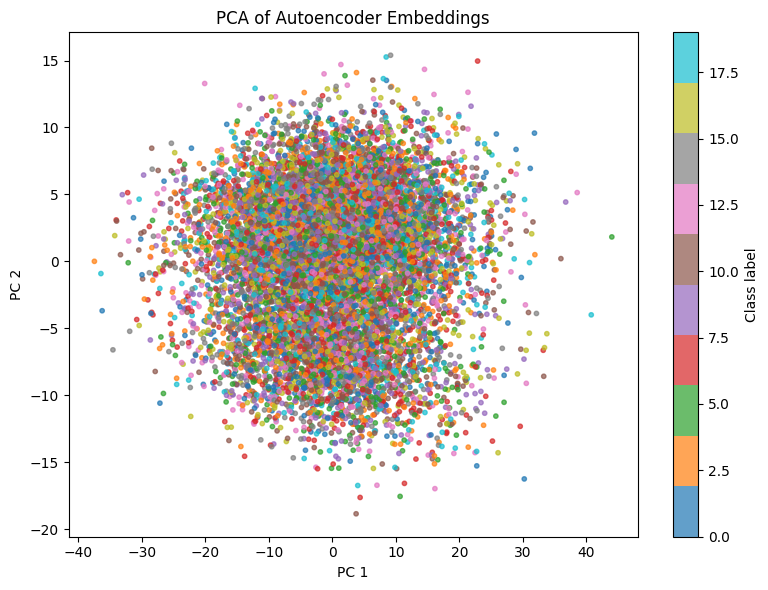

In [ ]:



X = embeddings_train.cpu().numpy()
y = y_train.cpu().numpy() if isinstance(y_train, torch.Tensor) else y_train


pca = PCA(n_components=2) # 2 components pca
X_pca = pca.fit_transform(X)

print(f"Explained Variance: {pca.explained_variance_ratio_.sum()*100:.2f}%")

# --- Plot 2D ---
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=y, cmap="tab10", s=10, alpha=0.7
)
plt.colorbar(scatter, label="Class label")
plt.title("PCA of Autoencoder Embeddings")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.tight_layout()
plt.show()


As we can see the points are not clustered well, this explains why the mlp discriminator performed so poorly

# Sentence Embeddings + MLP Discriminator

## Sentence embedding from words embedding mean

In [ ]:
from gensim.models import FastText


/home/stefano/Documents/UniLu/NaturalLanguageProcessing/competition/nlp_competition/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [73]:
embedder = FastText(x_train_raw, vector_size=100, window=3, min_count=1, workers=4, sg=1) # Importing an training a pre-trained word-embedder

In [54]:
embedder.save("embedder")

#### Calculating sentence embedding

In [74]:
def sentence_embedding(sentence, model):
    words = sentence.split()
    word_vectors = [model.wv[w] for w in words if w in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0) # using the mean approach

In [75]:
x_train_embedded = np.array([sentence_embedding(sentence,embedder) for sentence in x_train_raw])
x_val_embedded = np.array([sentence_embedding(sentence,embedder) for sentence in x_val_raw])
x_test_embedded = np.array([sentence_embedding(sentence,embedder) for sentence in x_test_raw])

Varianza spiegata: 80.82%


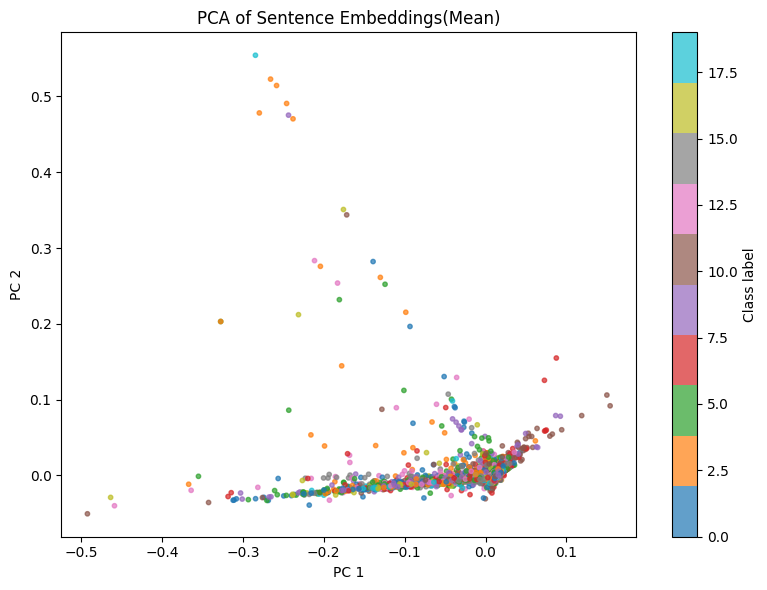

In [95]:

y = y_train

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_train_embedded)

print(f"Varianza spiegata: {pca.explained_variance_ratio_.sum()*100:.2f}%")

# --- Plot 2D ---
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=y, cmap="tab10", s=10, alpha=0.7
)
plt.colorbar(scatter, label="Class label")
plt.title("PCA of Sentence Embeddings(Mean)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.tight_layout()
plt.show()


Using mean we probably lose a lot of meaning, once again the points are not well separeted, we expect our mlp discriminator to perform poorly

Still not super clear separation but might work better

### Training utils

In [102]:
checkpoint_cb = ModelCheckpoint(
    monitor="val_f1",
    mode="max",
    save_top_k=1,
    filename="mlp-{epoch:02d}-{val_f1:.3f}"
)

early_stop_cb = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5,
    verbose=True,
    min_delta=0.001
)

progress_cb = RichProgressBar()

trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[checkpoint_cb, early_stop_cb, progress_cb],
    logger=False,
    #log_every_n_steps=50
)



GPU available: False, used: False
TPU available: False, using: 0 TPU cores


### Model definition

In [79]:
class LitFinalMLPClassifierEmbeddings(pl.LightningModule):
    def __init__(
        self,
        input_dim,
        num_classes,
        hidden=64,
        dropout=0.5,
        lr=1e-3,
        weight_decay=1e-4
    ):
        super().__init__()
        self.save_hyperparameters()

        # layers
        self.fc1 = nn.Linear(input_dim, hidden)
        self.bn1 = nn.BatchNorm1d(hidden)
        self.hidden2 = nn.Linear(hidden,hidden)
        self.fc_out = nn.Linear(hidden, num_classes)
        self.dropout = nn.Dropout(dropout)

        # metrics
        self.val_f1  = F1Score(task="multiclass", num_classes=num_classes, average="macro")
        self.test_f1 = F1Score(task="multiclass", num_classes=num_classes, average="macro")

    # forward
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.fc_out(x)
        x = F.softmax(x)
        return x

    # shared step
    def _shared_step(self, batch):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        return loss, preds, y

    # training
    def training_step(self, batch, batch_idx):
        loss, preds, y = self._shared_step(batch)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    # val
    def validation_step(self, batch, batch_idx):
        loss, preds, y = self._shared_step(batch)
        f1 = self.val_f1(preds, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_f1", f1, prog_bar=True)

    # test
    def test_step(self, batch, batch_idx):
        loss, preds, y = self._shared_step(batch)
        f1 = self.test_f1(preds, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_f1", f1, prog_bar=True)

    # predict
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x = batch[0]
        logits = self(x)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        return {"preds": preds.cpu(), "probs": probs.cpu()}

    # reset
    def on_validation_epoch_end(self):
        self.val_f1.reset()
    def on_test_epoch_end(self):
        self.test_f1.reset()

    def configure_optimizers(self):
        opt = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay
        )
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt,
            mode="min",
            factor=0.5,
            patience=2,
            min_lr=1e-6
        )
        return {"optimizer": opt, "lr_scheduler": {"scheduler": sched, "monitor": "val_loss"}}


### Data Loaders

In [80]:


X_train_e = torch.tensor(x_train_embedded, dtype=torch.float32)
X_val_e   = torch.tensor(x_val_embedded, dtype=torch.float32)
X_test_e  = torch.tensor(x_test_embedded, dtype=torch.float32)

y_train_e = torch.tensor(y_train, dtype=torch.long)
y_val_e   = torch.tensor(y_val, dtype=torch.long)
y_test_e  = torch.tensor(y_test, dtype=torch.long)

train_set = TensorDataset(X_train_e, y_train_e)
val_set   = TensorDataset(X_val_e, y_val_e)
test_set  = TensorDataset(X_test_e, y_test_e)

batch_size = 1024
train_loader_e = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=1)
val_loader_e   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=1)
test_loader_e  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=1)

### Training

### Mean Embeddings Model

In [81]:
input_dim = x_train_embedded.shape[1]
num_classes = len(target_names)
model_emb = LitFinalMLPClassifierEmbeddings(input_dim=input_dim,
    num_classes=num_classes)
print(model)

LitFinalMLPClassifierEmbeddings(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_out): Linear(in_features=64, out_features=20, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (val_f1): MulticlassF1Score()
  (test_f1): MulticlassF1Score()
)


In [82]:
trainer.fit(model_emb, train_loader_e, val_loader_e)

/home/stefano/Documents/UniLu/NaturalLanguageProcessing/competition/nlp_competition/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /home/stefano/Documents/UniLu/NaturalLanguageProcessing/competition/nlp_competition/checkpoints exists and is not empty.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ fc1     │ Linear            │ 19.3 K │ train │
│ 1 │ bn1     │ BatchNorm1d       │    128 │ train │
│ 2 │ hidden2 │ Linear            │  4.2 K │ train │
│ 3 │ fc_out  │ Linear            │  1.3 K │ train │
│ 4 │ dropout │ Dropout           │      0 │ train │
│ 5 │ val_f1  │ MulticlassF1Score │      0 │ train │
│ 6 │ test_f1 │ MulticlassF1Score │      0 │ train │
└───┴─────────┴───────────────────┴────────┴───────┘

Trainable params: 24.9 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 24.9 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 7                                                                                           
Modules in eval mode: 0

/home/stefano/Documents/UniLu/NaturalLanguageProcessing/competition/nlp_competition/.venv/lib/python3.12/site-packa
ges/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/stefano/Documents/UniLu/NaturalLanguageProcessing/competition/nlp_competition/.venv/lib/python3.12/site-packa
ges/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers 
which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the 
`DataLoader` to improve performance.

/tmp/ipykernel_21381/3905639164.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. 
Change the call to include dim=X as an argument.
  x = F.softmax(x)

/home/stefano/Documents/UniLu/NaturalLanguageProcessing/competition/nlp_competition/.venv/lib/python3.12/site-packa
ges/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers 
which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the 
`DataLoader` to improve performance.

Metric val_loss improved. New best score: 2.996
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 2.994
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 2.992
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 2.986
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 2.978
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 2.973
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 2.970
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 2.968
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 2.967
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 2.966
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 2.964
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 2.962
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 2.961
Metric val_loss 

As expected the model performs poorly 

## Sentence embeddings with BERT

In [ ]:
from sentence_transformers import SentenceTransformer
sentence_embedder = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2') # loading BERT

### Calculating sentence embeddings

In [ ]:
X_train_embedded_bert = sentence_embedder.encode(x_train_raw)
X_val_embedded_bert = sentence_embedder.encode(x_val_raw)
X_test_embedded_bert = sentence_embedder.encode(x_test_raw)

Varianza spiegata: 14.41%


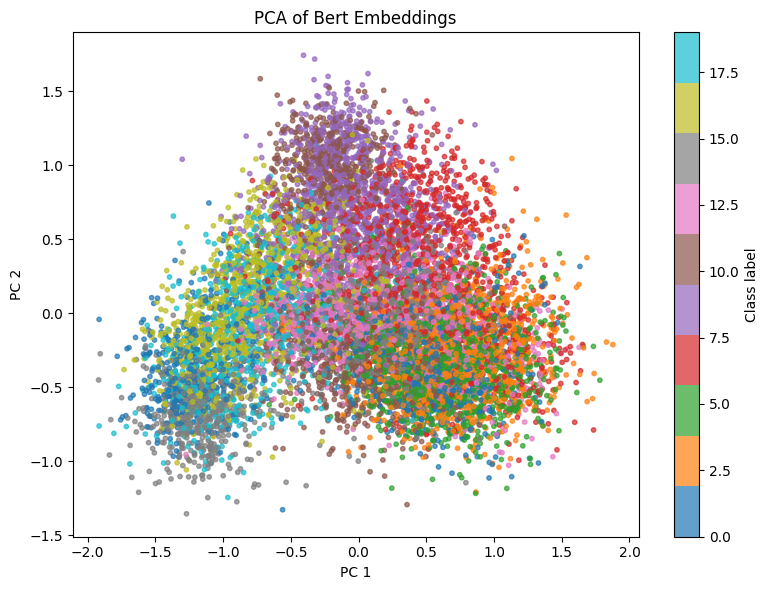

In [ ]:
y = y_train


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_embedded_bert)

print(f"Explained Variance: {pca.explained_variance_ratio_.sum()*100:.2f}%")

# --- Plot 2D ---
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=y, cmap="tab10", s=10, alpha=0.7
)
plt.colorbar(scatter, label="Class label")
plt.title("PCA of Bert Embeddings")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.tight_layout()
plt.show()


It seems like there is some kind of structure, but probably still not enough for the model to perform well

### Data Loaders

In [ ]:
X_train_e_bert = torch.tensor(X_train_embedded_bert, dtype=torch.float32)
X_val_e_bert   = torch.tensor(X_val_embedded_bert, dtype=torch.float32)
X_test_e_bert  = torch.tensor(X_test_embedded_bert, dtype=torch.float32)

y_train_e_bert = torch.tensor(y_train, dtype=torch.long)
y_val_e_bert   = torch.tensor(y_val, dtype=torch.long)
y_test_e_bert  = torch.tensor(y_test, dtype=torch.long)

train_set = TensorDataset(X_train_e_bert, y_train_e_bert)
val_set   = TensorDataset(X_val_e_bert, y_val_e_bert)
test_set  = TensorDataset(X_test_e_bert, y_test_e_bert)

batch_size = 1024
train_loader_e_bert = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=1)
val_loader_e_bert   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=1)
test_loader_e_bert  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=1)

### Model Definition

In [ ]:
input_dim = X_train_embedded_bert.shape[1]
num_classes = len(target_names)
model_emb_b = LitFinalMLPClassifierEmbeddings(input_dim=input_dim,
    num_classes=num_classes)
print(model_emb_b)

### Training

In [ ]:
trainer.fit(model_emb_b, train_loader_e_bert, val_loader_e_bert)

As expected the model performs poorly